In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
from PIL import Image
import os
import json
import matplotlib.pyplot as plt
import sklearn
import cv2
import time
import datetime

In [2]:
print("Is GPU available:", tf.config.list_physical_devices('GPU'))

Is GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [129]:
# Paths
images_dir = "/Users/finnferchau/dev/EH_Bottle_Dataset/cropped_images"
labels_dir = "/Users/finnferchau/dev/EH_Bottle_Dataset/labels"
labels_finetune_dir = "/Users/finnferchau/dev/EH_Bottle_Dataset/finetune_dataset_cropped/labels"
images_finetune_dir = "/Users/finnferchau/dev/EH_Bottle_Dataset/finetune_dataset_cropped/images"

def center_crop_and_resize(image_path, target_size=(224, 224)):
    """
    Crops the center square of an image and resizes it to the target size.

    Args:
        image_path (str): Path to the input image.
        target_size (tuple): Target size for resizing (width, height).

    Returns:
        PIL.Image.Image: The cropped and resized image.
    """

    image = Image.open(image_path)
    width, height = image.size

    # Calculate the cropping box for a center square
    min_dim = min(width, height)
    left = (width - min_dim) // 2
    top = (height - min_dim) // 2
    right = left + min_dim
    bottom = top + min_dim

    # Crop the center square
    image = image.crop((left, top, right, bottom))

    # Resize to the target size
    image = image.resize(target_size, Image.Resampling.LANCZOS)

    return image

# Load dataset
def load_dataset(images_dir, labels_dir):
    images = []
    labels = []
    for image_file in os.listdir(images_dir):
        if image_file.endswith(".jpg"):
            image_path = os.path.join(images_dir, image_file)
            label_path = os.path.join(labels_dir, image_file.replace(".jpg", ".json"))

            # Load and preprocess image
            image = center_crop_and_resize(image_path, target_size=(224, 224))  # Resize for ResNet50
            images.append(np.array(image) / 255.0)  # Normalize to [0, 1]

            # Load label
            with open(label_path, 'r') as f:
                label = json.load(f)
                labels.append([label["red_count"], label["green_count"], label["blue_count"]])

    return np.array(images), np.array(labels)

images, labels = load_dataset(images_dir, labels_dir)
finetune_images, finetune_labels = load_dataset(images_finetune_dir, labels_finetune_dir)
# augmented_images_dir = "/Users/finnferchau/dev/EH_Bottle_Dataset/augmented_dataset/images_augmented"
# augmented_labels_dir = "/Users/finnferchau/dev/EH_Bottle_Dataset/augmented_dataset/labels_augmented"
# augmented_images, augmented_labels = load_dataset(augmented_images_dir, augmented_labels_dir)


In [130]:
finetune_images.shape

(232, 224, 224, 3)

In [131]:
# Combine original and sampled finetune data
merged_images = np.concatenate([images, finetune_images], axis=0)
merged_labels = np.concatenate([labels, finetune_labels], axis=0)

# Shuffle the data
merged_images, merged_labels = sklearn.utils.shuffle(merged_images, merged_labels, random_state=42)

# Test-train split
X_train, X_test, y_train, y_test = train_test_split(merged_images, merged_labels, test_size=0.2, random_state=42)

# Print the sizes of the merged datasets
print(f"Total images: {merged_images.shape[0]}")
print(f"Total labels: {merged_labels.shape[0]}")

Total images: 2730
Total labels: 2730


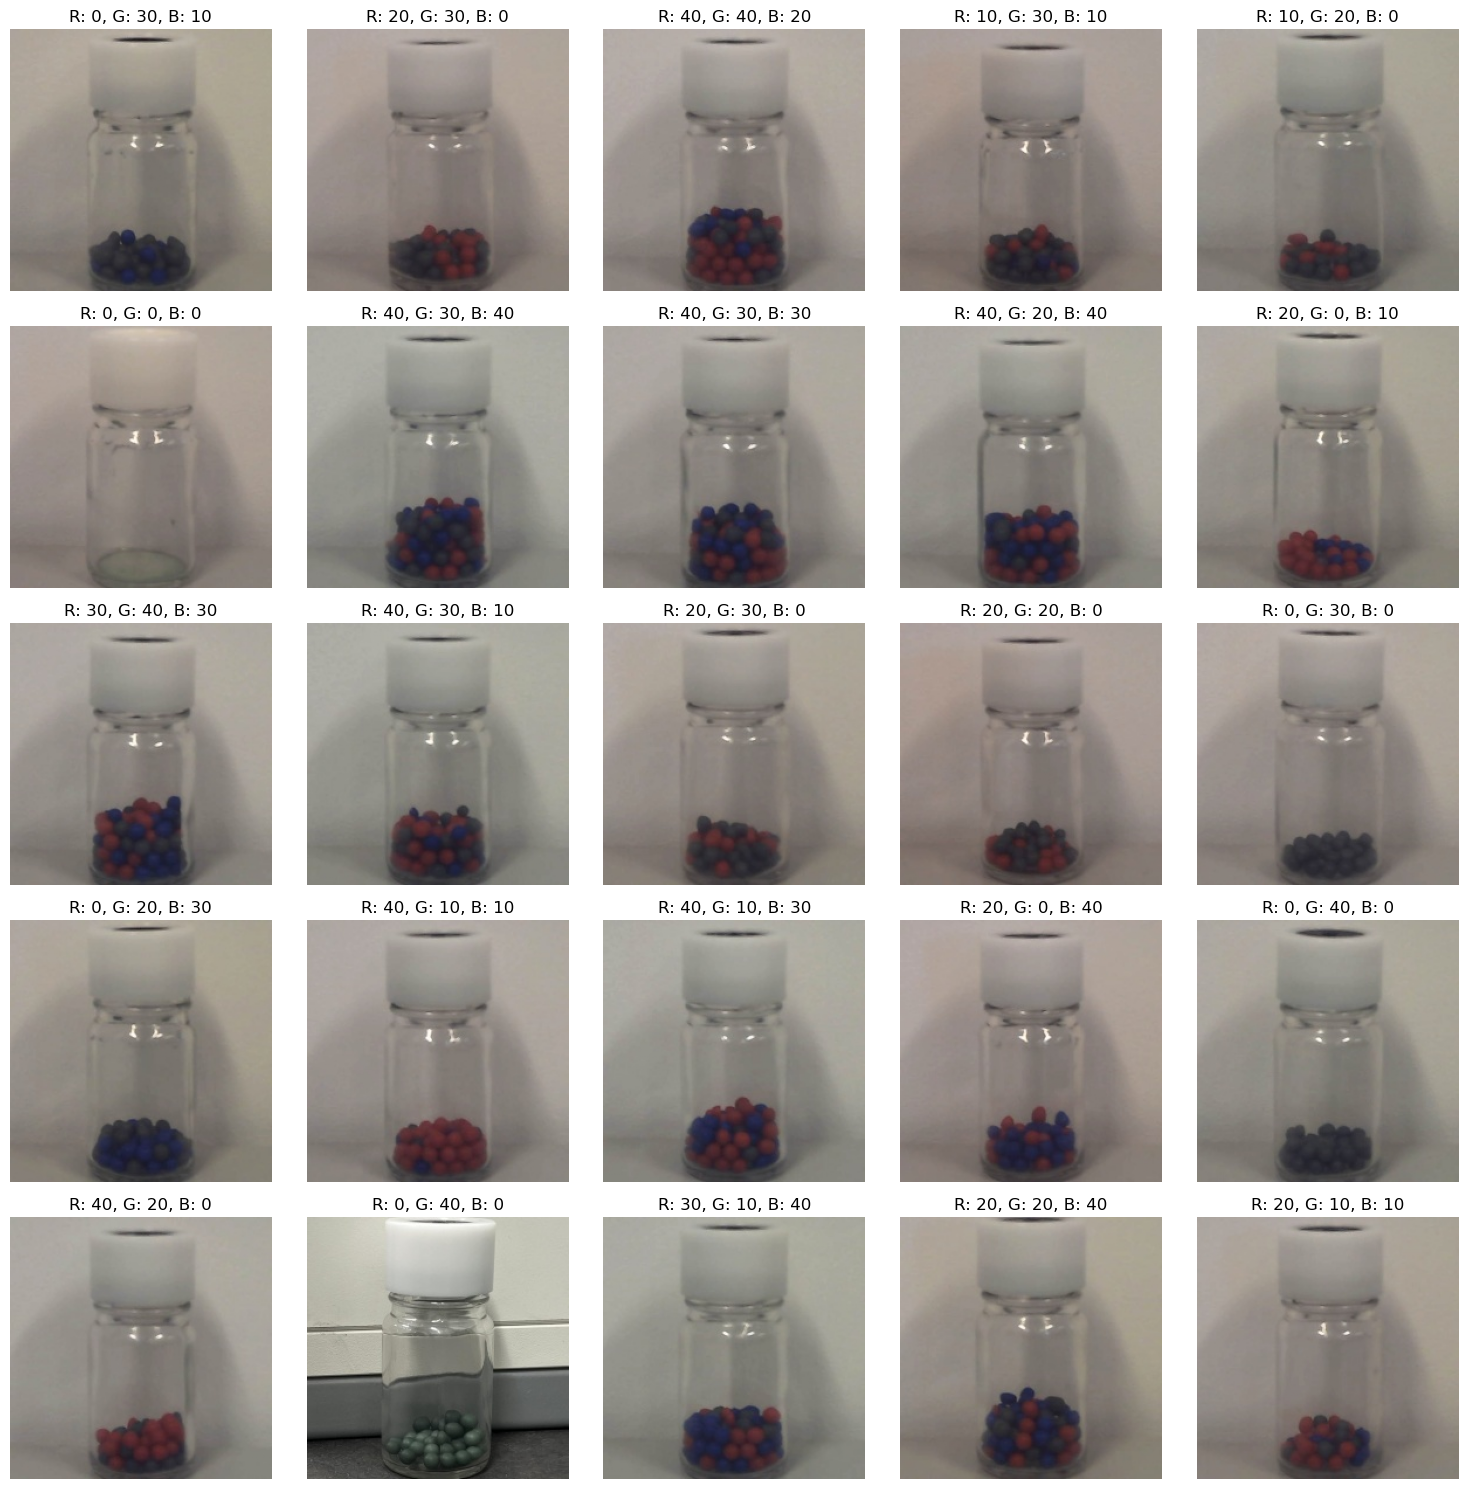

In [132]:
# Create a 5x5 grid of subplots
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))

# Flatten the axes for easier iteration
axs = axs.flatten()

# Plot the first 25 images and their labels
for idx, (image, label) in enumerate(zip(X_train[:25], y_train[:25])):
    axs[idx].imshow(image)
    axs[idx].set_title(f"R: {label[0]}, G: {label[1]}, B: {label[2]}")
    axs[idx].axis("off")  # Remove axes for clarity

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


In [40]:
# Load ResNet50 with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers for regression
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Sequential([
    Dense(128, activation='relu'),
    Dropout(0.5), 
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='linear')
])(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Display model summary
# model.summary()

In [134]:
model = tf.keras.models.load_model("/Users/finnferchau/dev/EH_Bottle_Dataset/models/resnet50_model_v20.keras")
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
sequential = model.layers[-1]
base_model_layers = model.layers[:-1]

# Freeze base model
# for layer in base_model_layers:
#    layer.trainable = False

In [135]:
# Data augmentation

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

# Augment the training data
datagen.fit(X_train)

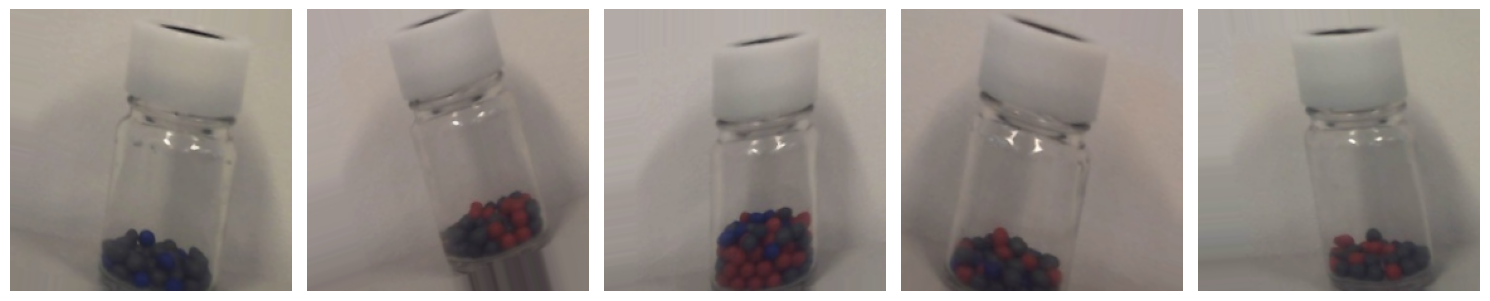

In [136]:
# Create an iterator for the data generator
image_iterator = datagen.flow(X_train, batch_size=1, shuffle=False)

# Visualize a few augmented images
num_images_to_display = 5  # Number of images to display
fig, axs = plt.subplots(1, num_images_to_display, figsize=(15, 15))

for i in range(num_images_to_display):
    augmented_image = image_iterator.__next__()[0]  # Get an augmented image
    axs[i].imshow(augmented_image)
    axs[i].axis('off')  # Turn off the axis for better visualization

plt.tight_layout()
plt.show()

In [116]:
# Training the model for 10 epochs

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=10
)

Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 35s 343ms/step - loss: 56.9697 - mae: 5.6978 - val_loss: 14.3509 - val_mae: 2.8601
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 13s 187ms/step - loss: 59.5909 - mae: 5.8663 - val_loss: 12.7293 - val_mae: 2.7982
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 13s 185ms/step - loss: 57.8782 - mae: 5.7975 - val_loss: 13.1871 - val_mae: 2.8509
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 13s 184ms/step - loss: 53.6627 - mae: 5.6366 - val_loss: 16.0118 - val_mae: 3.1450
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 13s 185ms/step - loss: 52.4765 - mae: 5.4695 - val_loss: 13.4181 - val_mae: 2.9094
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 13s 185ms/step - loss: 56.1432 - mae: 5.6613 - val_loss: 13.7490 - val_mae: 2.8354
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 13s 186ms/step - loss: 51.8844 - mae: 5.4385 - val_loss: 17.4090 - val_mae: 3.2478
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 13s 185ms/step - loss: 50.1880 - mae: 5.4225 - val_loss: 15.5878 - val_mae: 3.1103
Epoch 9/10
65/65 ━━━━━━━━━━━━━━━

In [139]:
# Save the model in TensorFlow SavedModel format
model.save("/Users/finnferchau/dev/EH_Bottle_Dataset/model.keras")

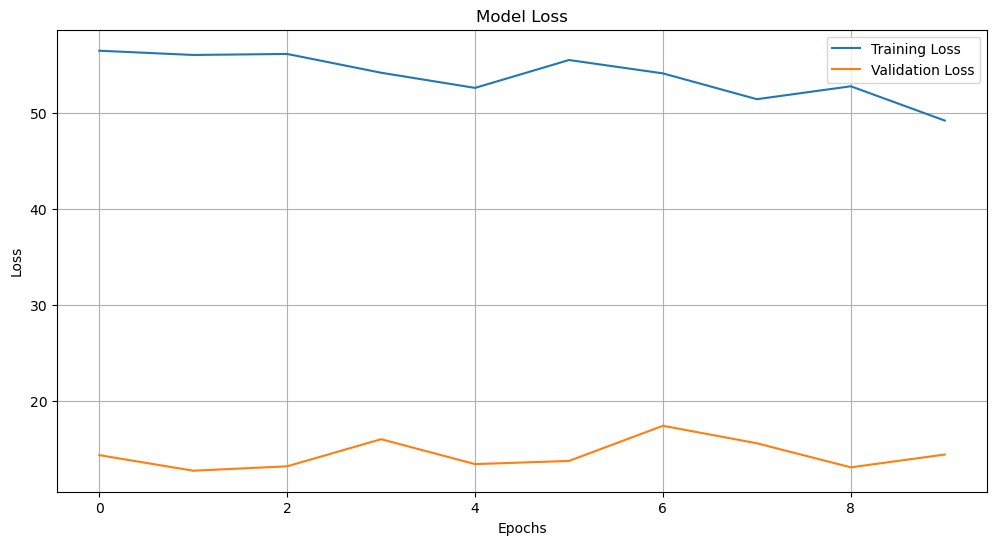

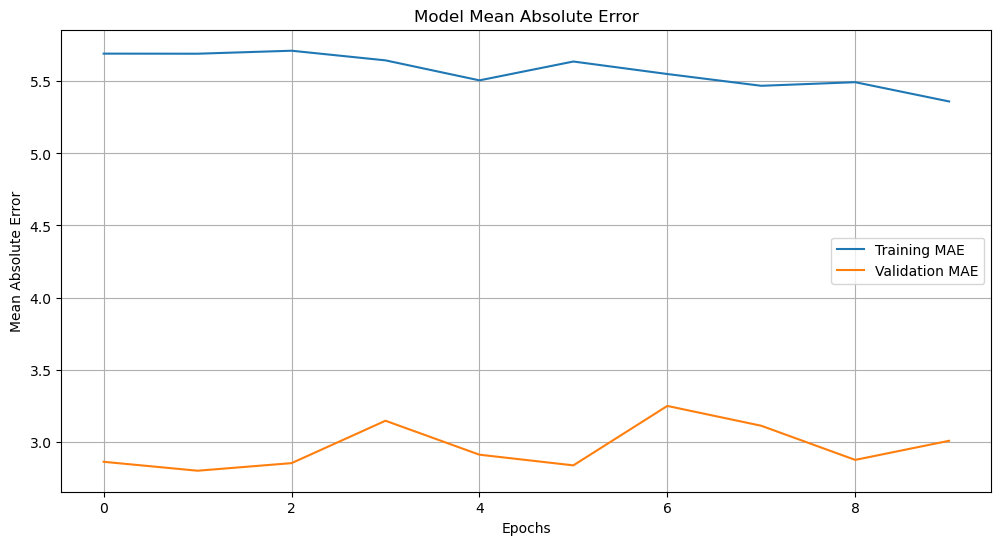

In [119]:
def plot_history(history):
    # Plot training & validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot training & validation metrics (e.g., MAE)
    plt.figure(figsize=(12, 6))
    plt.plot(history['mae'], label='Training MAE')
    plt.plot(history['val_mae'], label='Validation MAE')
    plt.title('Model Mean Absolute Error')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(history.history)

In [40]:
# Save the model as a .keras file
%tensorboard --logdir='/Users/finnferchau/dev/EH_Bottle_Dataset/logs/fit/'

Reusing TensorBoard on port 6006 (pid 11971), started 0:54:01 ago. (Use '!kill 11971' to kill it.)

In [137]:
log_dir = f"/Users/finnferchau/dev/EH_Bottle_Dataset/logs/fit/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"

# Training the model for 20 more epochs with all layers unfrozen

# Unfreeze the base model
for layer in base_model_layers:
    layer.trainable = True

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='/Users/finnferchau/dev/EH_Bottle_Dataset/best_model.keras',       # Filepath to save the model
    monitor='val_loss',            # Metric to monitor (e.g., validation loss)
    save_best_only=True,           # Save only the best model
    save_weights_only=False,       # Save the entire model (weights + architecture)
    mode='min',                    # Save when 'val_loss' is minimized
    verbose=1                      # Print messages when saving
)

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

# Train the model with the checkpoint callback
history_fine_tune = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=50,
    callbacks=[checkpoint_callback, tensorboard_callback]
)

Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 48.6440 - mae: 5.3165
Epoch 1: val_loss improved from inf to 29.60554, saving model to /Users/finnferchau/dev/EH_Bottle_Dataset/best_model.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - loss: 48.6395 - mae: 5.3155 - val_loss: 29.6055 - val_mae: 3.9875
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 48.3042 - mae: 5.2956
Epoch 2: val_loss improved from 29.60554 to 14.32923, saving model to /Users/finnferchau/dev/EH_Bottle_Dataset/best_model.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - loss: 48.3085 - mae: 5.2955 - val_loss: 14.3292 - val_mae: 3.1188
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 48.7925 - mae: 5.3390
Epoch 3: val_loss did not improve from 14.32923
69/69 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 48.7799 - mae: 5.3377 - val_loss: 22.8321 - val_mae: 3.6514
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - loss: 48.2060 - mae: 5.2575
Epoch 4: val_loss did not improve from 14.32923
69/69 ━━━━━━

KeyboardInterrupt: 

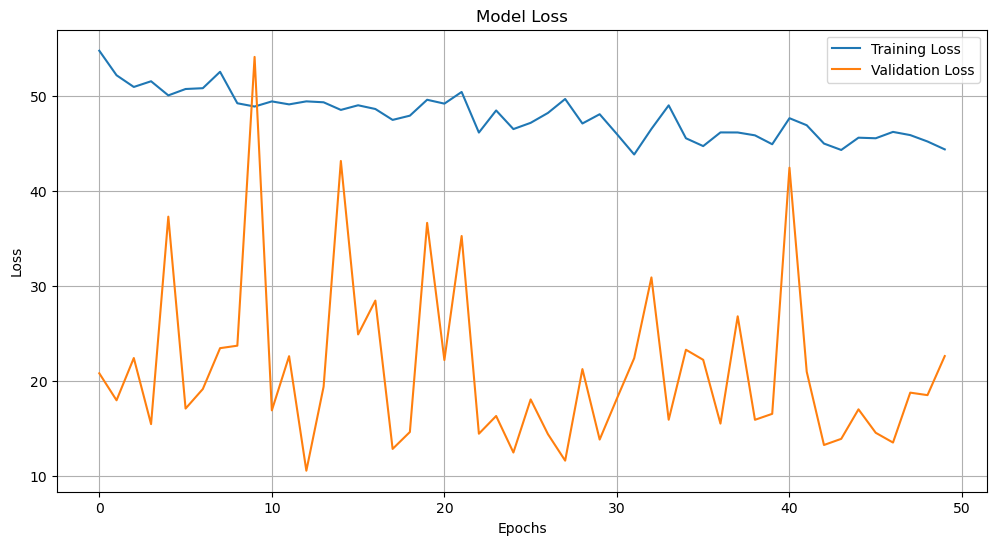

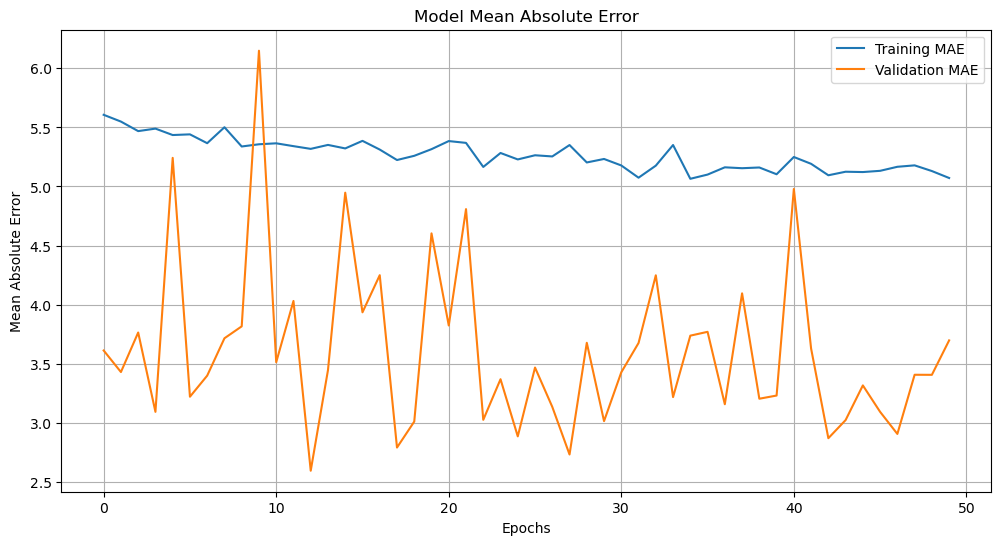

In [121]:
plot_history(history_fine_tune.history)

In [142]:
# Load the saved model
model = tf.keras.models.load_model('/Users/finnferchau/dev/EH_Bottle_Dataset/models/resnet50_model_v21.keras')

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - loss: 10.7547 - mae: 2.6413
Test Loss: 10.635723114013672, Test MAE: 2.650829792022705


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[[14.532194   1.5506077 37.51792  ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[[31.41958   9.913043 20.71571 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
[[14.483814 38.563274 22.837461]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[0.5559266 7.709807  8.928045 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[27.408836 14.011844 12.319095]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[[ 2.414542 31.271646 31.303356]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[16.777063 37.79233  20.330532]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[12.285049 37.71256  34.726955]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[[ 3.7863789 38.766094  35.301407 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[[27.296928   1.3628368 10.092263 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[[21.9996   30.725372 17.216461]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[29.588947 32.788162 33.245472]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[ 0.44208652 10.400477   11.18343   ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[32.341553 3

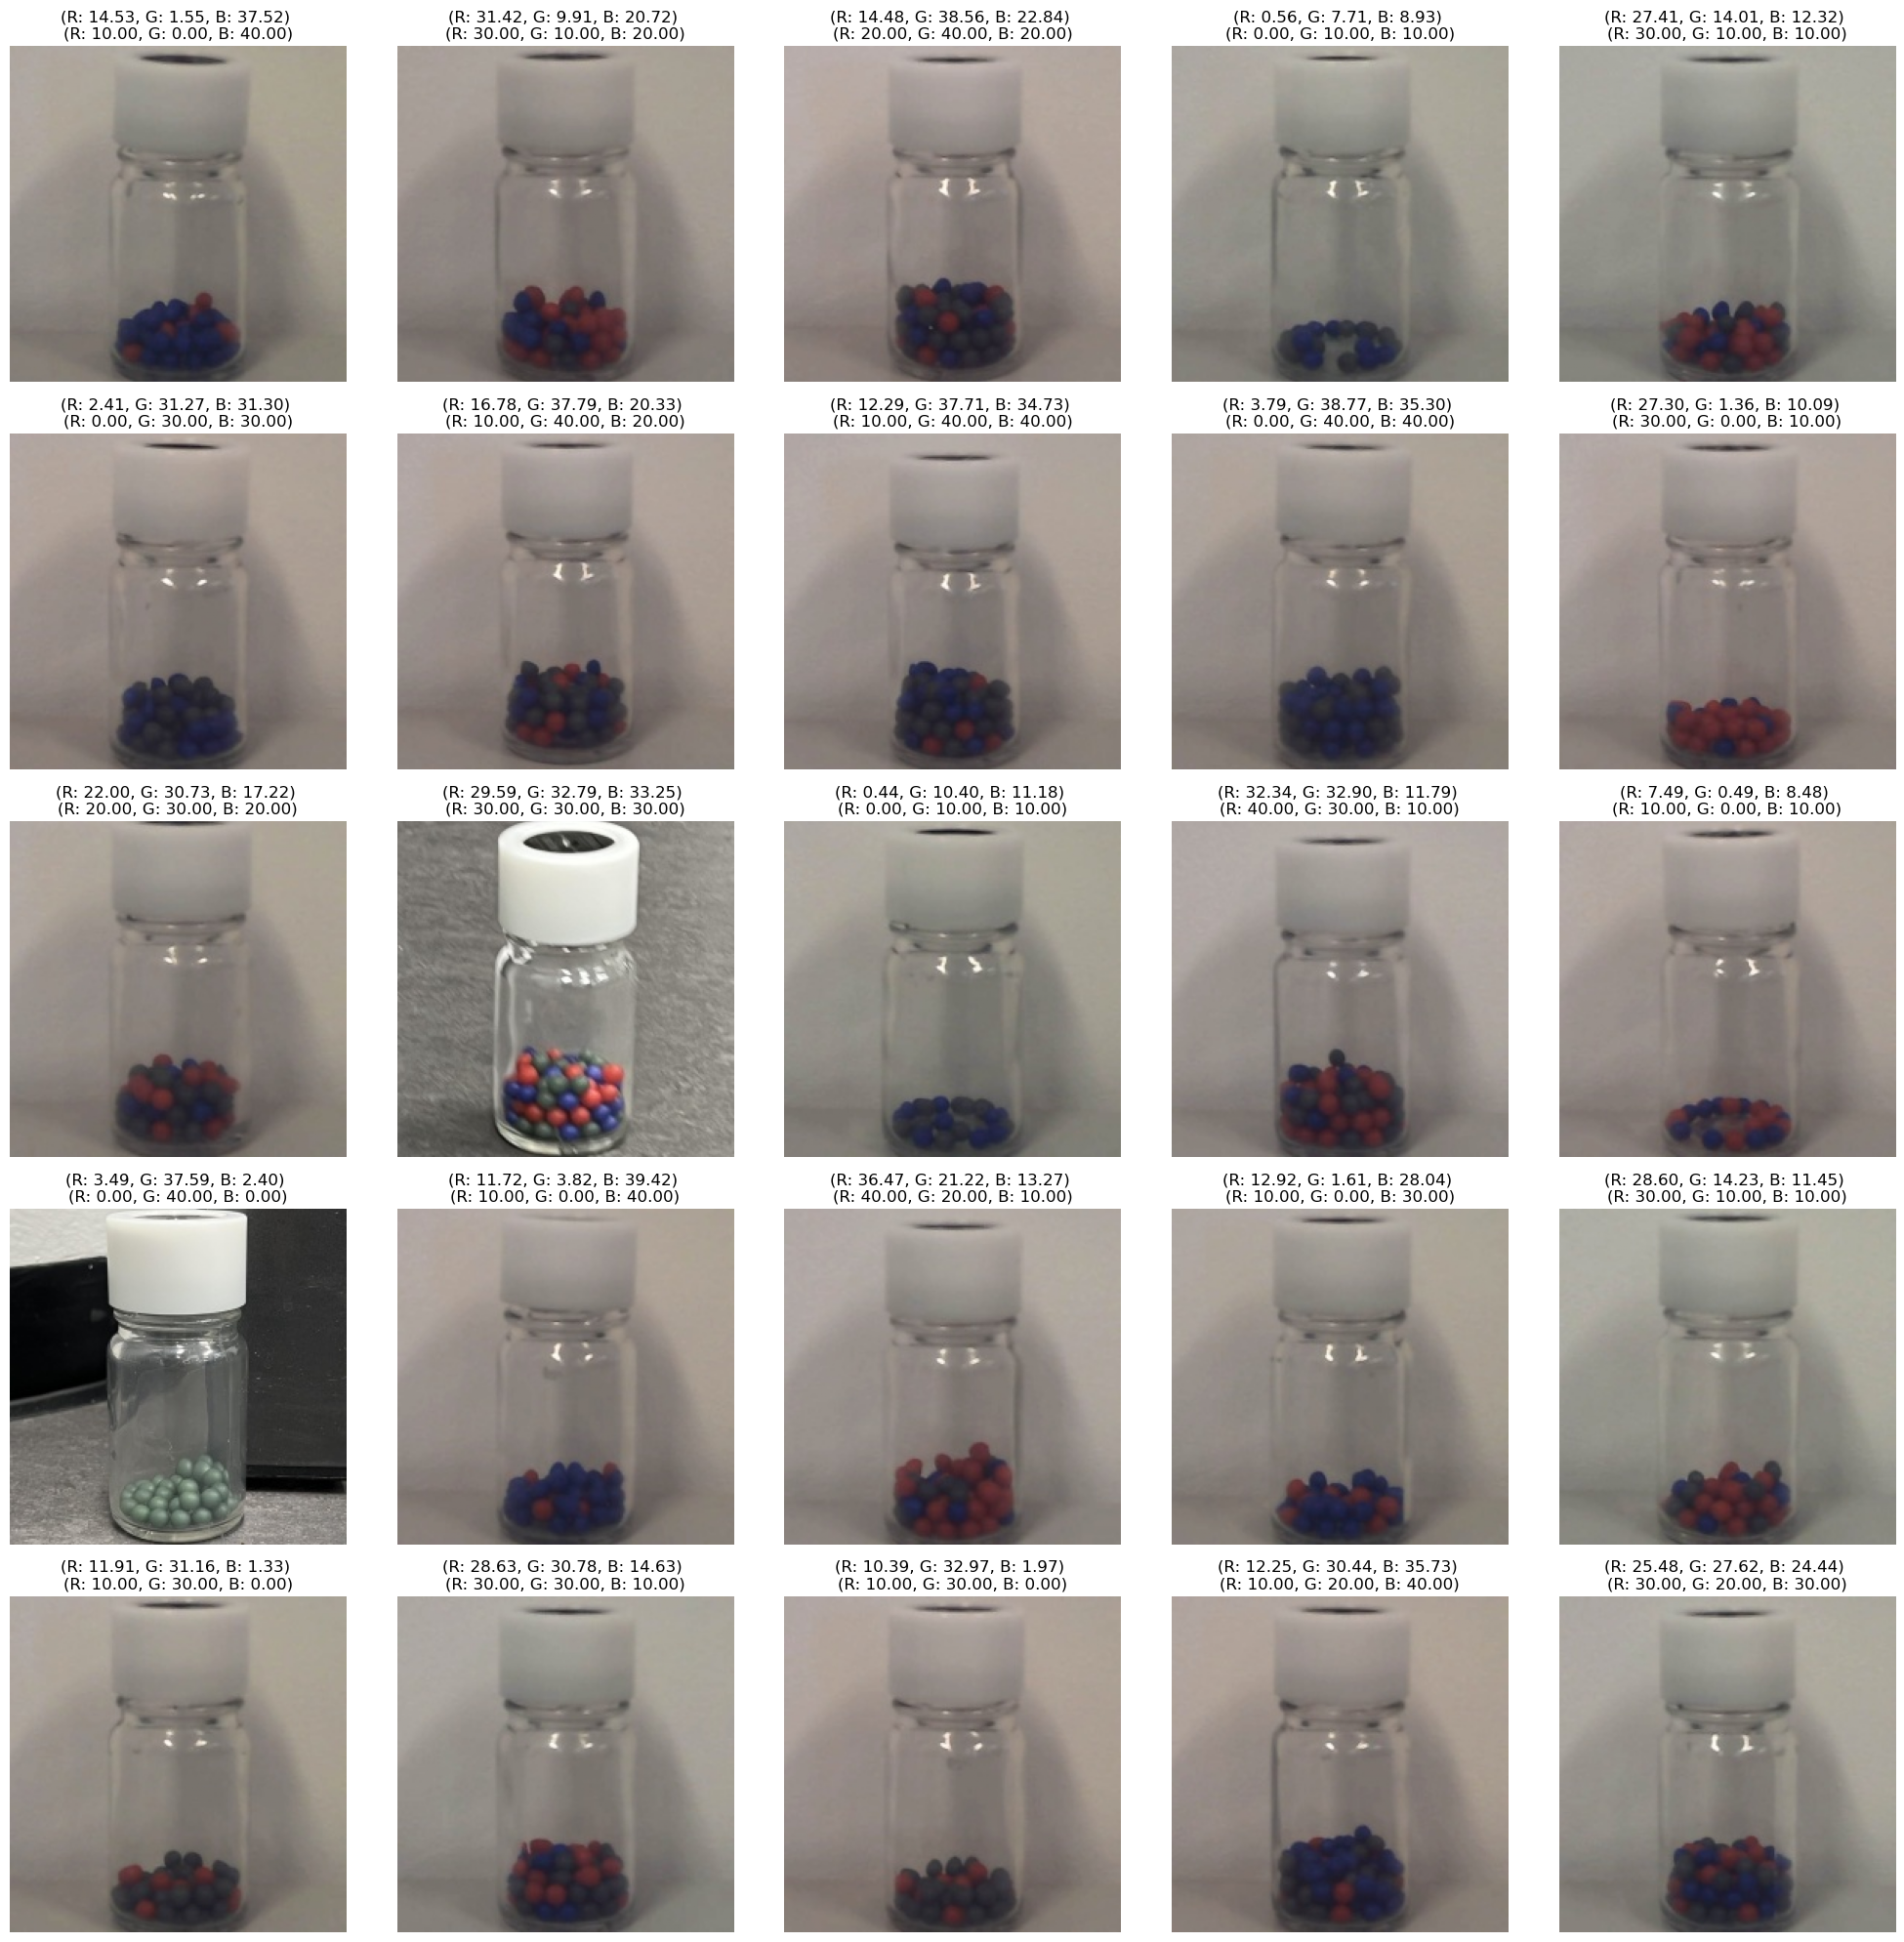

In [143]:
predictions = []

for img, label in zip(X_test[:25], y_test[:25]):
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    print(prediction)
    predictions.append((img, label, prediction[0]))

# Create a 5x5 grid of subplots
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

# Flatten the axes for easier iteration
axs = axs.flatten()

# Plot the first 25 images and their labels
for idx, (image,label, prediction) in enumerate(predictions):
    axs[idx].imshow(image[0])
    axs[idx].set_title(f"(R: {prediction[0]:.2f}, G: {prediction[1]:.2f}, B: {prediction[2]:.2f}) \n(R: {label[0]:.2f}, G: {label[1]:.2f}, B: {label[2]:.2f})")    
    axs[idx].axis("off")  # Remove axes for clarity

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [27]:
import pandas as pd

model_dir = "/Users/finnferchau/dev/EH_Bottle_Dataset/models"
test_scores = []

for file_name in os.listdir(model_dir):
    if file_name.endswith(".keras"):
        model_path = os.path.join(model_dir, file_name)
        model = tf.keras.models.load_model(model_path)
        test_loss, test_mae = model.evaluate(X_test, y_test)
        test_scores.append((test_loss, test_mae, file_name))

df = pd.DataFrame(test_scores)
df

/opt/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 438 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - loss: 193.8790 - mae: 11.8240
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 250ms/step - loss: 195.3931 - mae: 11.9355
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 218ms/step - loss: 195.9850 - mae: 12.0018
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - loss: 199.9881 - mae: 12.1784
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - loss: 166.0547 - mae: 10.0764
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 255ms/step - loss: 144.7239 - mae: 9.2435
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 233ms/step - loss: 18.1770 - mae: 3.3403
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 247ms/step - loss: 17.1729 - mae: 3.2232
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 255ms/step - loss: 60.7577 - mae: 5.8523
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - loss: 303.8648 - mae: 14.1610
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 231ms/step - loss: 66.2579 - mae: 6.2327


0          1                         2
0   198.844208  12.044896   resnet50_model_v4.keras
1   200.035202  12.140274   resnet50_model_v6.keras
2   199.267563  12.165736   resnet50_model_v7.keras
3   204.006210  12.339516   resnet50_model_v5.keras
4   165.561172  10.017282   resnet50_model_v9.keras
5   145.711197   9.231652  resnet50_model_v11.keras
6    17.893435   3.307393  resnet50_model_v13.keras
7    16.875597   3.201345  resnet50_model_v14.keras
8    59.115791   5.815965  resnet50_model_v12.keras
9   299.300751  13.948209   resnet50_model_v8.keras
10   66.711723   6.224004  resnet50_model_v10.keras

In [30]:
df.columns = ["Mean Loss", "MAE", "Model Name"]
df.sort_values("MAE")

Mean Loss        MAE                Model Name
7    16.875597   3.201345  resnet50_model_v14.keras
6    17.893435   3.307393  resnet50_model_v13.keras
8    59.115791   5.815965  resnet50_model_v12.keras
10   66.711723   6.224004  resnet50_model_v10.keras
5   145.711197   9.231652  resnet50_model_v11.keras
4   165.561172  10.017282   resnet50_model_v9.keras
0   198.844208  12.044896   resnet50_model_v4.keras
1   200.035202  12.140274   resnet50_model_v6.keras
2   199.267563  12.165736   resnet50_model_v7.keras
3   204.006210  12.339516   resnet50_model_v5.keras
9   299.300751  13.948209   resnet50_model_v8.keras